In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# import warnings
# warnings.filterwarnings("error")

C:\Users\bhagyashreeG\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
read=pd.read_csv("train_ps0mmDv_9yr6iGN/train/train_submissions.csv")
problem=pd.read_csv("train_ps0mmDv_9yr6iGN/train/problem_data.csv")
user=pd.read_csv("train_ps0mmDv_9yr6iGN/train/user_data.csv")
test=pd.read_csv("test_submissions_NeDLEvX.csv")

In [3]:
test1=test.merge(problem,on='problem_id').merge(user,on='user_id')

In [4]:
train=read.merge(user,on='user_id').merge(problem,on='problem_id')

In [5]:
train.isna().any()

user_id                      False
problem_id                   False
attempts_range               False
submission_count             False
problem_solved               False
contribution                 False
country                       True
follower_count               False
last_online_time_seconds     False
max_rating                   False
rating                       False
rank                         False
registration_time_seconds    False
level_type                    True
points                        True
tags                          True
dtype: bool

###### Preprocessing & Exploratory Analysis

In [6]:
train['level_type'].unique()

array(['B', 'A', 'C', 'D', 'E', 'G', 'I', 'F', 'H', nan, 'J', 'K', 'L',
       'M', 'N'], dtype=object)

In [7]:
train['level_type'] = train['level_type'].fillna(train['level_type'].mode()[0])
test1['level_type'] = test1['level_type'].fillna(test1['level_type'].mode()[0])

In [8]:
train['level_type'].unique()

array(['B', 'A', 'C', 'D', 'E', 'G', 'I', 'F', 'H', 'J', 'K', 'L', 'M',
       'N'], dtype=object)

In [9]:
LevelType=train.groupby('level_type')['user_id'].nunique().reset_index()

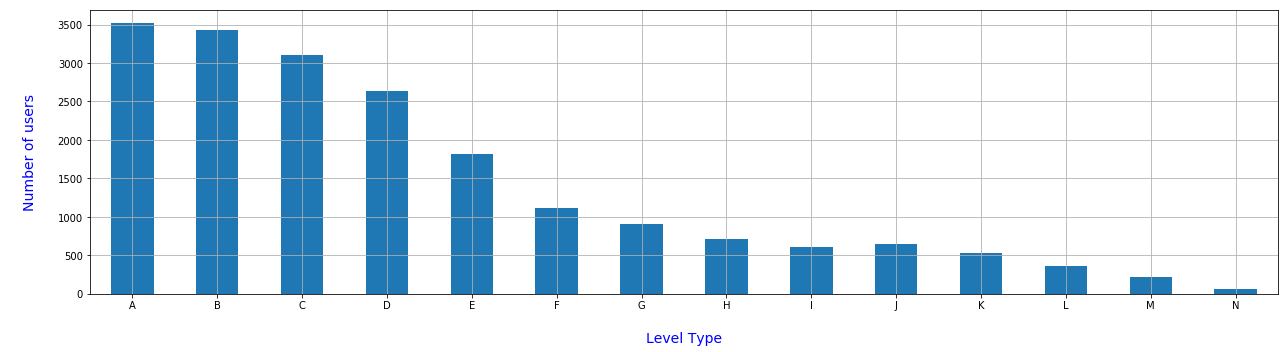

In [10]:
LevelType.set_index('level_type')['user_id'].plot.bar(figsize=(18,5),grid=True,rot=0)
plt.xlabel("\nLevel Type",fontsize=14,color='blue')
plt.ylabel("\nNumber of users\n",fontsize=14,color='blue')
plt.tight_layout()

In [11]:
le = LabelEncoder()
train['level_type'] = le.fit_transform(train['level_type'])
test1['level_type'] = le.transform(test1['level_type'])

In [12]:
train['rank'].unique()

array(['beginner', 'intermediate', 'advanced', 'expert'], dtype=object)

In [13]:
Rank=train.groupby('rank')['user_id'].nunique().reset_index()

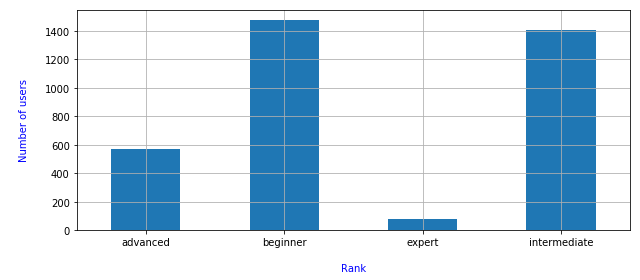

In [14]:
Rank.set_index('rank')['user_id'].plot.bar(figsize=(9,4),grid=True,rot=0)
plt.xlabel("\nRank",fontsize=10,color='blue')
plt.ylabel("\nNumber of users\n",fontsize=10,color='blue')
plt.tight_layout()

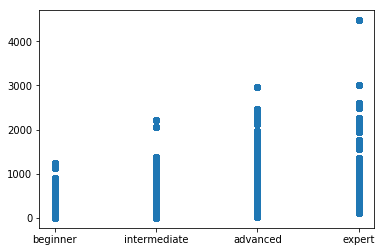

In [15]:
plt.scatter(x=train['rank'],y=train['problem_solved'])

In [16]:
le = LabelEncoder()
train['rank'] = le.fit_transform(train['rank'])
test1['rank'] = le.transform(test1['rank'])

In [17]:
country=train.groupby('country')['user_id'].nunique().reset_index()

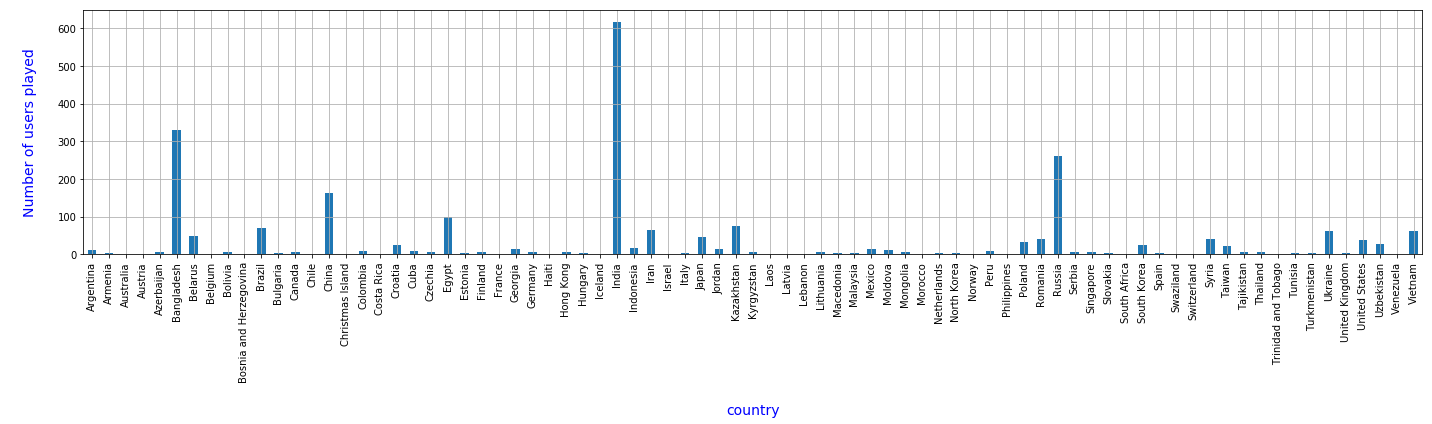

In [18]:
country.set_index('country')['user_id'].plot.bar(figsize=(20,6),grid=True,rot=90)
plt.xlabel("\ncountry",fontsize=14,color='blue')
plt.ylabel("\nNumber of users played\n",fontsize=14,color='blue')
plt.tight_layout()

In [19]:
train['country'] = train['country'].fillna(train['country'].mode()[0])
test1['country'] = test1['country'].fillna(test1['country'].mode()[0])
train['country'] = le.fit_transform(train['country'])
test1['country'] = le.fit_transform(test1['country'])

In [20]:
train['user_id']=train['user_id'].str.replace('user_','')
test1['user_id'] = test1['user_id'].str.replace('user_','')
train['problem_id'] = train['problem_id'].str.replace('prob_','')
test1['problem_id'] = test1['problem_id'].str.replace('prob_','')

In [21]:
train['diffonlinesec']=train['last_online_time_seconds']-train['registration_time_seconds']
test1['diffonlinesec']=test1['last_online_time_seconds']-test1['registration_time_seconds']
#####################################
train['days']=train['diffonlinesec']//(24*3600)
test1['days']=test1['diffonlinesec']//(24*3600)

In [22]:
train['tags']=train['tags'].fillna('-999')
test1['tags']=test1['tags'].fillna('-999')

In [23]:
le = LabelEncoder()
train['tags'] = le.fit_transform(train['tags'])
test1['tags'] = le.fit_transform(test1['tags'])

In [24]:
train['sumfollower']=train.groupby('user_id')['follower_count'].transform('sum')
train['AvgProblemsolved']=train.groupby('user_id')['problem_solved'].transform('mean')
train['SumProblemsolved']=train.groupby('user_id')['problem_solved'].transform('sum')
##########################
test1['sumfollower']=test1.groupby('user_id')['follower_count'].transform('sum')
test1['AvgProblemsolved']=test1.groupby('user_id')['problem_solved'].transform('mean')
test1['SumProblemsolved']=test1.groupby('user_id')['problem_solved'].transform('sum')

In [25]:
train['sumcontribution']=train.groupby('user_id')['contribution'].transform('sum')
#####################
test1['sumcontribution']=test1.groupby('user_id')['contribution'].transform('sum')

In [26]:
# train['user_id'] = le.fit_transform(train['user_id'])
# train['problem_id'] = le.fit_transform(train['problem_id'])
train['user_id'] = train['user_id'].astype('int')
train['problem_id'] = train['problem_id'].astype('int')
#############################
# test1['user_id'] = le.fit_transform(test1['user_id'])
# test1['problem_id'] = le.fit_transform(test1['problem_id'])
test1['user_id'] = test1['user_id'].astype('int')
test1['problem_id'] = test1['problem_id'].astype('int')

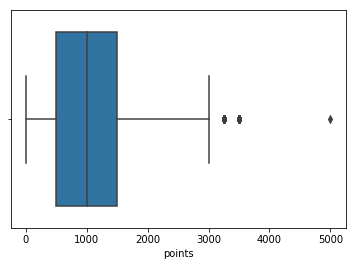

In [204]:
ax = sns.boxplot(x=train['points'])

In [27]:
qt = QuantileTransformer(output_distribution='normal')
train['points']=train['points'].fillna(train['points'].median())
train['npoints'] = qt.fit_transform(train[['points']].values)
#######################
test1['points']=test1['points'].fillna(test1['points'].median())
test1['npoints'] = qt.fit_transform(test1[['points']].values)

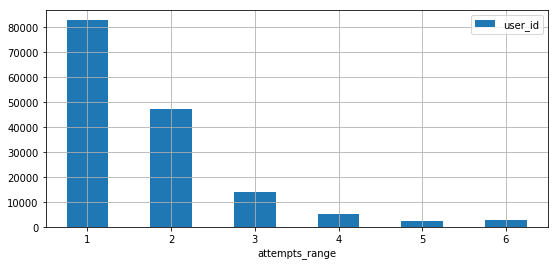

In [28]:
attemptRange=train.groupby('attempts_range').count()['user_id'].reset_index()
attemptRange.set_index('attempts_range').plot.bar(figsize=(9,4),grid=True,rot=0)

In [29]:
train['submission_count_norm']=np.cbrt(train['submission_count'])

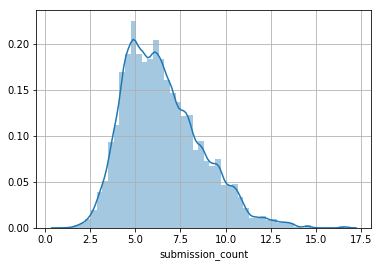

In [30]:
sns.distplot(np.cbrt(train['submission_count']))
plt.grid()

In [33]:
train['attempts_range'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [32]:
train['attempts_range']=train['attempts_range'].replace(1,0).replace(2,1).replace(3,2).replace(4,3).replace(5,4).replace(6,5)

###### Model Training

In [73]:
X1=train.drop(['npoints','rank','contribution','submission_count_norm','AvgProblemsolved','sumcontribution',
               'problem_solved','follower_count','diffonlinesec','days','max_rating','attempts_range'],axis=1)
Y1=train['attempts_range']

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2,random_state=123,stratify=Y1)

In [75]:
Counter(y_train),Counter(y_test)

(Counter({0: 66243, 1: 37856, 2: 11314, 3: 4399, 5: 2427, 4: 1997}),
 Counter({1: 9464, 0: 16561, 5: 606, 4: 499, 2: 2829, 3: 1100}))

In [113]:
params={}
params['learning_rate']=0.02
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=30
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value
params['lambda_l1']=0.01 
params['min_child_weight']= 5
params['colsample_bytree']= 0.5
#params['min_data_in_leaf']=1000
params['num_leaves']=60

In [114]:
import lightgbm as lgb

In [115]:
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(x_train, label=y_train)

In [116]:
clf=lgb.train(params,d_train,900)  #training the model on 100 epocs

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2389
[LightGBM] [Info] Number of data points in the train set: 124236, number of used features: 12
[LightGBM] [Info] Start training from score -0.628853
[LightGBM] [Info] Start training from score -1.188393
[LightGBM] [Info] Start training from score -2.396142
[LightGBM] [Info] Start training from score -3.340806
[LightGBM] [Info] Start training from score -4.130537
[LightGBM] [Info] Start training from score -3.935527


In [117]:
y_pred_1=clf.predict(x_test)
#printing the predictions
y_pred_1

array([[0.51379919, 0.31420508, 0.10134988, 0.04096537, 0.01674112,
        0.01293935],
       [0.45228583, 0.33517948, 0.18384421, 0.01491818, 0.0120751 ,
        0.0016972 ],
       [0.80962707, 0.15337577, 0.02697255, 0.00776287, 0.00112989,
        0.00113185],
       ...,
       [0.32108828, 0.2990815 , 0.22064185, 0.07977142, 0.06077699,
        0.01863996],
       [0.48787635, 0.34032036, 0.11294482, 0.04493943, 0.00888794,
        0.0050311 ],
       [0.69639852, 0.22752205, 0.04565982, 0.019566  , 0.00681715,
        0.00403646]])

In [118]:
y_pred_1 = [np.argmax(line) for line in y_pred_1]

In [119]:
accuracy_score(y_pred_1,y_test),f1_score(y_pred_1,y_test,average='weighted'),

(0.5561672945040085, 0.6384464961543269)

In [120]:
train1=clf.predict(x_train)
t1=[np.argmax(line) for line in train1]

In [121]:
accuracy_score(t1,y_train),f1_score(t1,y_train,average='weighted')

(0.62003767024051, 0.6876525865356047)

In [122]:
set(y_pred_1),set(t1)

({0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5})

##### Feature Importance

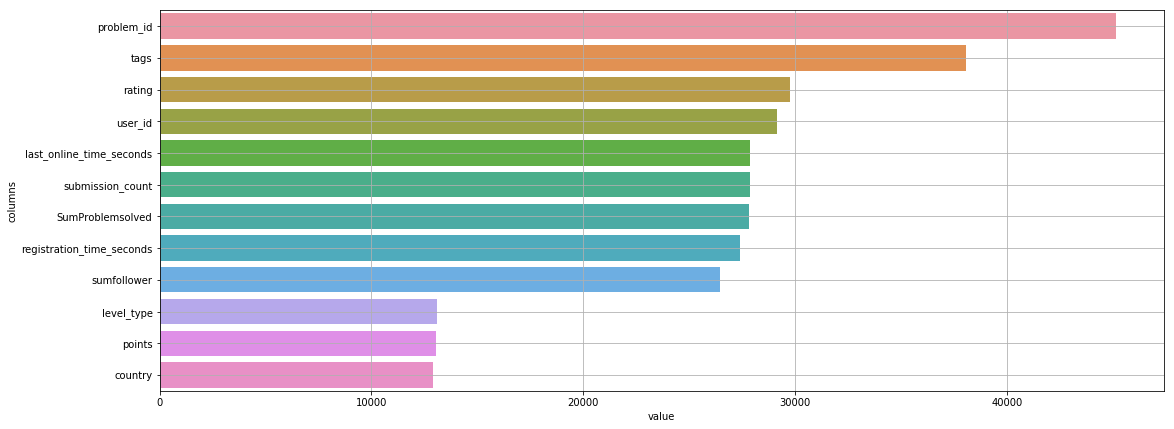

In [123]:
df1=pd.DataFrame()
df1['value']=clf.feature_importance()
df1['columns']=x_train.columns
df1.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(18,7))
ax = sns.barplot(y="columns", x="value", data=df1)
plt.grid()

##### Prediction on test dataset

In [125]:
testtest=test1.drop(['ID','npoints','rank','contribution','AvgProblemsolved','sumcontribution',
               'problem_solved','follower_count','diffonlinesec','days','max_rating'],axis=1)

In [126]:
testtest.columns

Index(['user_id', 'problem_id', 'level_type', 'points', 'tags',
       'submission_count', 'country', 'last_online_time_seconds', 'rating',
       'registration_time_seconds', 'sumfollower', 'SumProblemsolved'],
      dtype='object')

In [127]:
x_train.columns

Index(['user_id', 'problem_id', 'submission_count', 'country',
       'last_online_time_seconds', 'rating', 'registration_time_seconds',
       'level_type', 'points', 'tags', 'sumfollower', 'SumProblemsolved'],
      dtype='object')

In [128]:
testtest=testtest[['user_id', 'problem_id', 'submission_count', 'country',
       'last_online_time_seconds', 'rating', 'registration_time_seconds',
       'level_type', 'points', 'tags', 'sumfollower', 'SumProblemsolved']]

In [129]:
prediction=clf.predict(testtest)

In [131]:
PredictionResult=[np.argmax(line) for line in prediction]

In [138]:
set(PredictionResult)

{0, 1, 2, 3, 4, 5}

In [134]:
testtest['user_id']=testtest['user_id'].astype('str')
testtest['problem_id']=testtest['problem_id'].astype('str')
testtest['ID']="user_"+testtest['user_id']+"_"+"prob_"+testtest['problem_id']

In [139]:
testtest['attempts_range']=PredictionResult

In [141]:
testtest0=testtest[testtest['attempts_range']==0]
testtest0['attempts_range']=1

C:\Users\bhagyashreeG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
testtest1=testtest[testtest['attempts_range']==1]
testtest1['attempts_range']=2
testtest2=testtest[testtest['attempts_range']==2]
testtest2['attempts_range']=3
testtest3=testtest[testtest['attempts_range']==3]
testtest3['attempts_range']=4
testtest4=testtest[testtest['attempts_range']==4]
testtest4['attempts_range']=5
testtest5=testtest[testtest['attempts_range']==5]
testtest5['attempts_range']=6

C:\Users\bhagyashreeG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bhagyashreeG\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\bhagyashreeG\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [147]:
concat=pd.concat([testtest0,testtest1,testtest2,testtest3,testtest4,testtest5])

In [148]:
concat

,user_id,problem_id,submission_count,country,last_online_time_seconds,rating,registration_time_seconds,level_type,points,tags,sumfollower,SumProblemsolved,ID,attempts_range
0,856,5822,274,31,1503233908,362.959,1422163139,11,1000.0,16,840,5544,user_856_prob_5822,1
1,856,6173,274,31,1503233908,362.959,1422163139,1,1000.0,755,840,5544,user_856_prob_6173,1
2,856,5781,274,31,1503233908,362.959,1422163139,0,500.0,747,840,5544,user_856_prob_5781,1
3,856,3438,274,31,1503233908,362.959,1422163139,0,500.0,746,840,5544,user_856_prob_3438,1
4,856,1868,274,31,1503233908,362.959,1422163139,0,500.0,757,840,5544,user_856_prob_1868,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66415,3518,6261,823,73,1505506233,612.099,1281961523,5,1000.0,16,1320,10860,user_3518_prob_6261,6
66443,444,4303,650,55,1505571056,561.927,1362871465,5,1000.0,16,1120,19616,user_444_prob_4303,6
66447,444,4388,650,55,1505571056,561.927,1362871465,4,1000.0,16,1120,19616,user_444_prob_4388,6
66450,444,4872,650,55,1505571056,561.927,1362871465,5,1000.0,16,1120,19616,user_444_prob_4872,6


In [150]:
concat['attempts_range'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [151]:
test_prediction=concat[['ID','attempts_range']]

In [152]:
test_prediction.to_csv("test_prediction.csv",index=False,header=test_prediction.columns)